# Create a dataset object from crowd_human data

The class PersonDataset is getting images of a similar aspect ratio and resizing them to (400, 600) so as to prevent too much distortion of the images and so generating anchors can be uniform across all images. Max objects is set to a low number for computational efficiency and all images with < max objects are padded. Anchors points are are going to be uniformly placed across the image which will be used as points to segment the image. These segmentation will be used to develop a region proposal method as well as form sub images where classification can occur. This project is still in progress, with the region proposal network still being developed. Currently, this model classifies background or person across all anchor generated bounding boxes.

In [1]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch
from utils import *

class PersonDataset(Dataset):

    def __init__(self, annot_path, img_dir, img_dim, categories):
        self.annot_path = annot_path
        self.img_dir =  img_dir
        self.img_dim =  img_dim
        self.categories =  categories

        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
    
    def __len__(self):
        return len(self.img_data_all)
    
    def __getitem__(self, index):
        return self.img_data_all[index], self.gt_bboxes_all[index], self.gt_classes_all[index]
    
    def get_data(self):
        max_objects = 10
        
        #get_boxes_all has shape (B, n_images, max_objects, 4) where B is batch size
        df_images = filter_aspect_ratio(self.annot_path, 1.6, 1.4)
        gt_boxes_all, gt_idxs_all, img_data_all = load_dataset(self.annot_path, self.img_dir, max_objects, self.img_dim, df_images)

        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1) #pad if there are images with < max_objects
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)

        img_data_stacked = torch.stack(img_data_all, dim=0)

        print('total length of image data is', len(img_data_stacked))
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [2]:
img_width = 600
img_height = 400
name2idx = {'pad': -1, 'person': 1}
categories = {v:k for k, v in name2idx.items()}

annotation_path = './mmdetection/data/coco/annotations/instances_train2017.json'
image_dir = './mmdetection/data/coco/train2017/'
od_dataset = PersonDataset(annotation_path, image_dir, (img_height, img_width), categories)
od_dataloader = DataLoader(od_dataset, batch_size=2)

100%|██████████| 200/200 [00:26<00:00,  7.65it/s]


total length of image data is 74


Lets demonstrate the preprocessing on a couple of images. First we need to generate features for these images, using resnet pretrained model. This will reduce the load/computational power required for the model

In [3]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break #just get the first batch
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

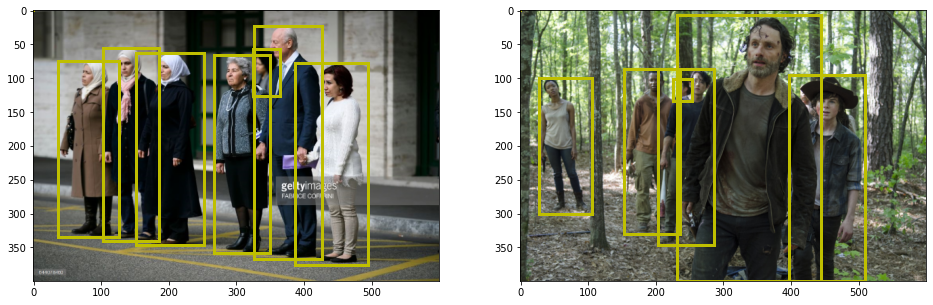

In [4]:
import matplotlib.pyplot as plt

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], in_format='xywh')
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], in_format='xywh')

Above demonstrates an image with bounding boxes applied. Next we will reduce these images to multiple chanels/layers with reduced dimensions using the resent pretrained model. 

In [7]:
from model import *

model = FeatureExtractor()
out = model(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

/Users/jacinta/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jacinta/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(2048, 13, 19)

The anchors will also need to be scaled along side this feature extraction so we define scaling factors

In [8]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(30, 31)

Plot the feature extracted images -> this new axis will be used as the basis for the anchor points across the images

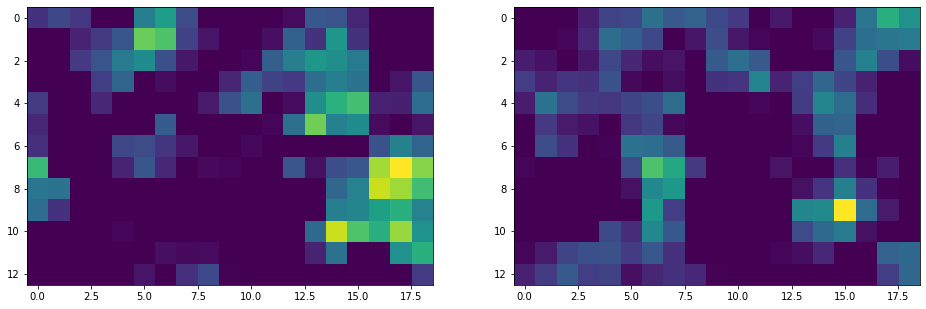

In [9]:
feature_extracted_data =[extracted[0].detach().numpy() for extracted in out[:2]]

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(feature_extracted_data, fig, axes)

So lets create anchor points on this image

In [11]:
#arange points along the length of the height and width
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

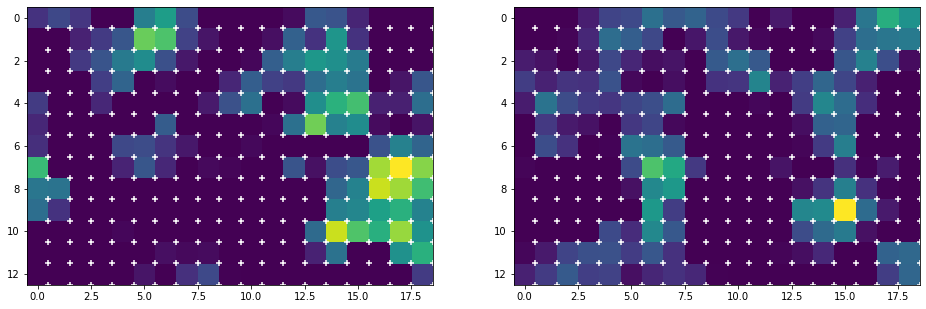

In [12]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(feature_extracted_data, fig, axes)
fig, _ = display_grid(anc_pts_x, anc_pts_y, fig, axes[0])
fig, _ = display_grid(anc_pts_x, anc_pts_y, fig, axes[1])

Lets see this on the raw image - the anchor points will need to scaled up with the scaling_factor

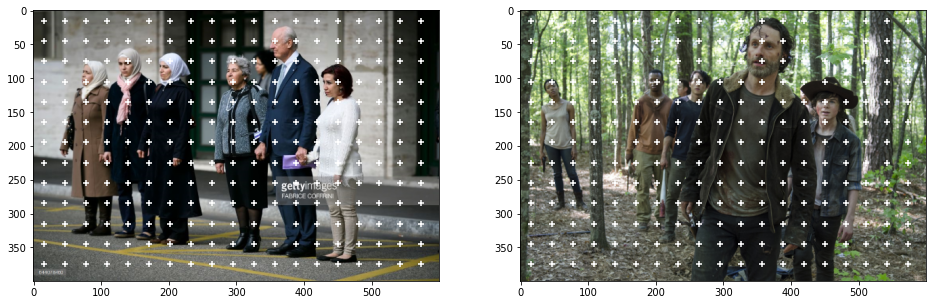

In [13]:
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

Now we want to start generating anchors for each anchor point. There will be 9 anchors per anchor point, based on the scale as well as the aspect ratio.

In [14]:
anc_scales = [2, 6, 10]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point
anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))
anc_boxes_all = anc_base.repeat(len(img_data_all), 1, 1, 1, 1)

Lets's see what this looks like on an image and on an extracted feature map.

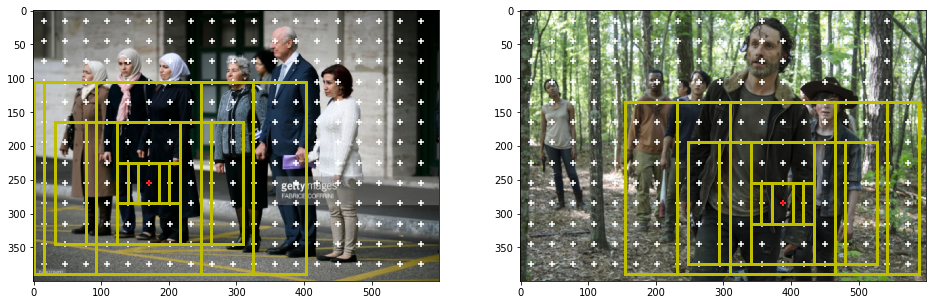

In [16]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image -> remember anc_boxes in format xyxy while ground truth bounding boxes are in xywh format
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, in_format='xyxy')

# plot anchor boxes around selected/specific anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0], in_format='xyxy')
fig, _ = display_bbox(bboxes_2, fig, axes[1], in_format='xyxy')

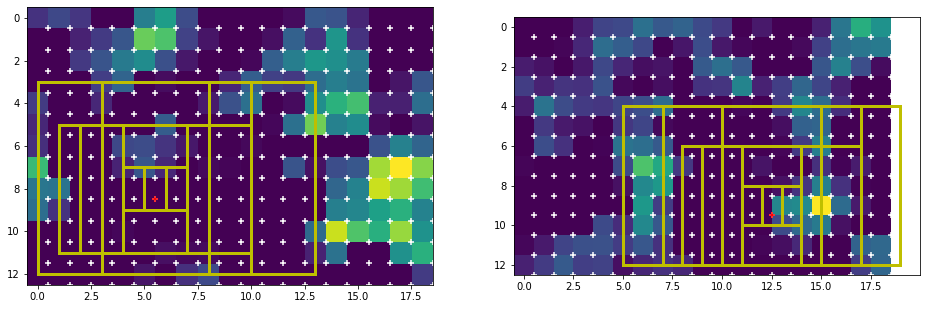

In [18]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

bboxes_1 = anc_boxes_all[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_all[1][sp_2[0], sp_2[1]]

fig, axes = display_img(feature_extracted_data, fig, axes)
fig, _ = display_grid(anc_pts_x, anc_pts_y, fig, axes[0], (anc_pts_x[sp_1[0]], anc_pts_y[sp_1[1]]))
fig, _ = display_grid(anc_pts_x, anc_pts_y, fig, axes[1], (anc_pts_x[sp_2[0]], anc_pts_y[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0], in_format='xyxy')
fig, _ = display_bbox(bboxes_2, fig, axes[1], in_format='xyxy')

Now we need to generate anchors which have a large overlap with a ground truth box. One way to optimise this is by re-adjusting the ground truth bounding boxes to the nearest grid location. Let's plot how the projected ground truth boxes look.

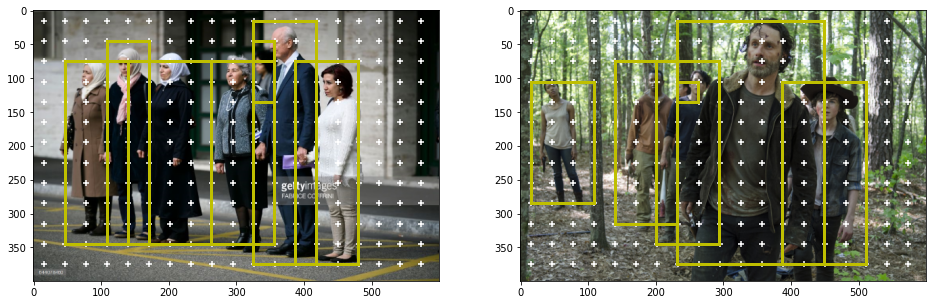

In [19]:
gt_bboxes_proj = bboxes_to_nearest_anchors(gt_bboxes_all, anc_pts_x_proj, anc_pts_y_proj, in_format='xywh') #this function also switched function to xyxy
bboxes_1 = gt_bboxes_proj[0]
bboxes_2 = gt_bboxes_proj[1]

nrows, ncols = (1, 2)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])
fig, _ = display_bbox(bboxes_1, fig, axes[0], in_format='xyxy')
fig, _ = display_bbox(bboxes_2, fig, axes[1], in_format='xyxy')

Now, finally, lets find generated anchors that have a significant overlap with the projected ground truth boxes. These will be used in training to aid classification from generated & proposed bounding box regions

In [36]:
pos_thresh = 0.95
neg_thresh = 0.3

positive_anc_ind, negative_anc_ind, GT_conf_scores,  \
GT_class_pos, positive_anc_coords, negative_anc_coords,  \
positive_anc_ind_sep, GT_bboxes_pos= get_req_anchors(anc_boxes_proj, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

In [37]:
#seperate anchors by image
positive_anc_coords_sep = []
for index in range(img_data_all.size(dim=0)):
    positive_anc_coords_sep.append(positive_anc_coords[(positive_anc_ind_sep==index)])

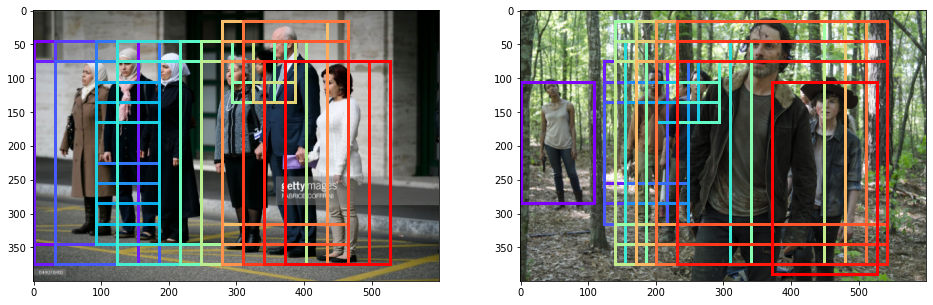

In [38]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(positive_anc_coords_sep[0], fig, axes[0], color='vary', in_format='xyxy')
fig, _ = display_bbox(positive_anc_coords_sep[1], fig, axes[1], color='vary', in_format='xyxy')